## Import the model and weights


In [4]:
from modeling.titok import *
from omegaconf import OmegaConf 
config = OmegaConf.load("configs/training/stage1/titok_l32_CSL.yaml")
model = TiTok(config)
weights = "../TiTok_weights/ema_model/pytorch_model.bin"

# load the weights 
model.load_state_dict(torch.load(weights))

<All keys matched successfully>

### Checking validation images

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S001978_P0004_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S001978_P0004_T00\000008.jpg
orginal image: torch.Size([3, 256, 256])


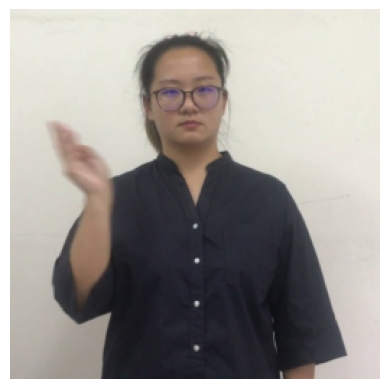

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


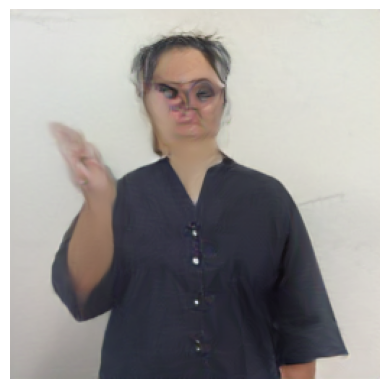

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S005365_P0006_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S005365_P0006_T00\000156.jpg
orginal image: torch.Size([3, 256, 256])


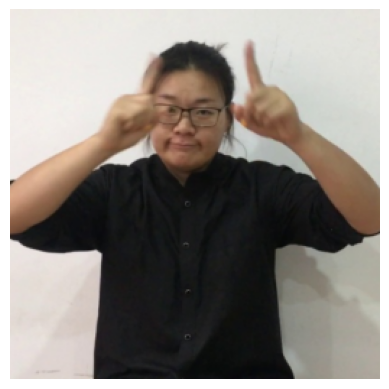

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


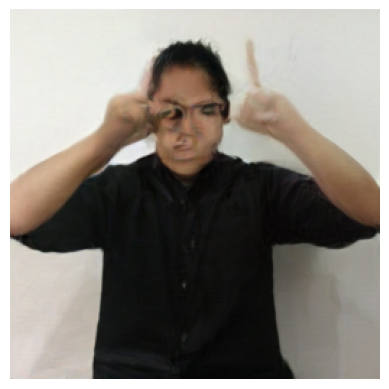

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S002441_P0005_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S002441_P0005_T00\000000.jpg
orginal image: torch.Size([3, 256, 256])


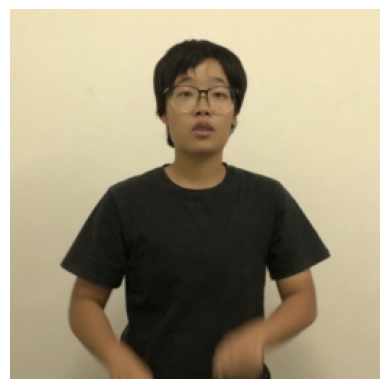

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


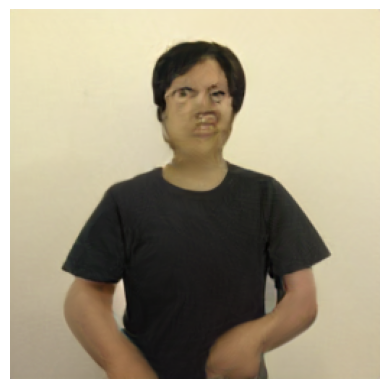

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S006127_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S006127_P0000_T00\000062.jpg
orginal image: torch.Size([3, 256, 256])


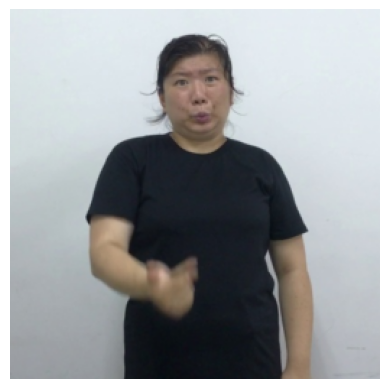

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


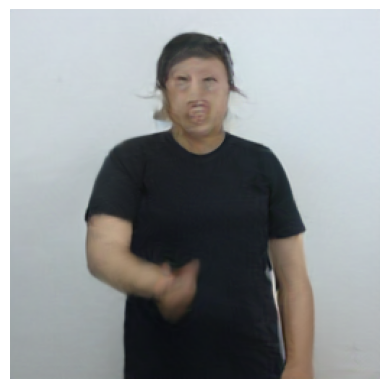

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000083.jpg
orginal image: torch.Size([3, 256, 256])


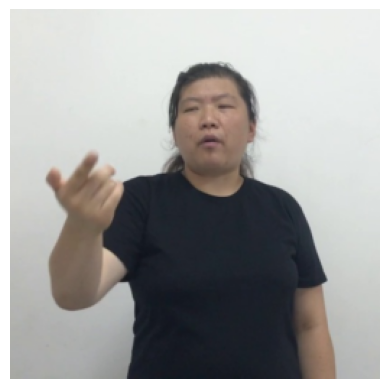

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


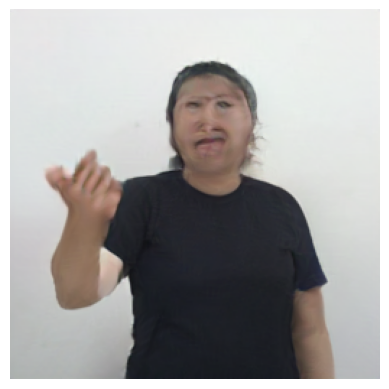

In [5]:
import os
import random
from PIL import Image
import numpy as np 
from torchvision import transforms
from IPython.display import display 
import matplotlib.pyplot as plt


maskgit =  PretrainedTokenizer(config.model.vq_model.pretrained_tokenizer_weight).to("cuda")
def tokenize_and_reconstruct(model, img_path=None, encoded_tokens=None):
    # Preprocess the image  
    image = Image.open(img_path).convert("RGB")
    person_size = 410
    # Calculate the center horizontal crop and lower vertical crop
    x_start = int((image.size[0] - person_size) // 2)  # Center horizontally
    x_end = x_start + person_size
    y_start = image.size[1] - person_size # Crop the lower vertical section
    y_end = image.size[1]

    # Crop the image (keeping center horizontal and lower vertical)
    image = image.crop((x_start, y_start, x_end, y_end))
    # add transforms 
    # Normalization values for ImageNet
    norm_mean = [0,0,0]
    norm_std = [1,1,1]
    # Data transformations for validation and test sets (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to fixed size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(norm_mean, norm_std)  # Normalize using ImageNet statistics
    ])

    image = eval_transform(image)
    print(f"orginal image: {image.shape}")
    # Plot the image
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.axis('off')  # Remove axis
    plt.show()
    model = model.to("cuda")

    image = torch.from_numpy(np.array(image).astype(np.float32)).unsqueeze(0)
    if analyse_tensor== False: 
        encoded_tokens = model.encode(image.to("cuda"))[1]["min_encoding_indices"]
    print(f"encoded tokens: {encoded_tokens.shape}")
    reconstructed_image = model.decode_tokens(encoded_tokens)
    reconstructed_image = maskgit.decode(reconstructed_image.argmax(1))
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).to("cpu", dtype=torch.uint8).numpy()[0].transpose(1, 2, 0)
    #reconstructed_image = Image.fromarray(reconstructed_image.transpose(1, 2, 0))
    #print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    
    print(f"reconstructed image: {reconstructed_image.shape}")
    # Plot the image
    plt.imshow(reconstructed_image  )
    plt.axis('off')  # Remove axis
    plt.show()

img_path = config.dataset.params.img_path + "/dev"
# Get a list of all folders in the image path
folders = [os.path.join(img_path, folder) for folder in os.listdir(img_path) if os.path.isdir(os.path.join(img_path, folder))]

for i in range(5): 
    # Select a random folder
    random_folder = random.choice(folders)
    print(f"random folder: {random_folder}")
    # Get a list of all images in the selected folder
    analyse_tensor = False
    if analyse_tensor : 
        encoded_tokens = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.pt'))]
        random_token = random.choice(encoded_tokens)
        print(f"random token file: {random_token}")
        random_token = torch.load(random_token).unsqueeze(0).unsqueeze(0).cuda()
        print(f"encoded tokens: {random_token}")
    else: 
        images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Select a random image
    random_image_path = random.choice(images)
    print(f"random image: {random_image_path}")




    # Get the reconstuction + Display the reconstructed image
    tokenize_and_reconstruct(model=model, img_path=random_image_path, encoded_tokens=None)

### Testing decoding from 32 Tokens

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S002086_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000033.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000033.pt
encoded tokens: tensor([[[3847, 3708, 2372,  740, 4004, 2673, 1317, 1222, 3682, 1732, 3873,
          2486, 3554,  454, 2338, 2301, 2202, 1454, 1984, 2430, 1732,  419,
          2423, 2341,  910, 1909, 2782, 3160, 4033, 2713, 1506,  713]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


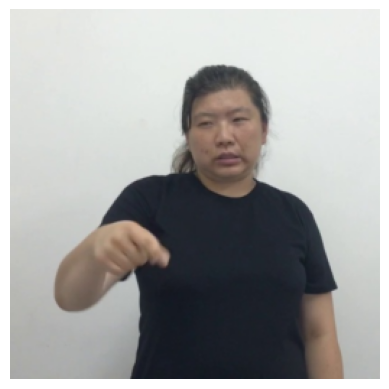

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


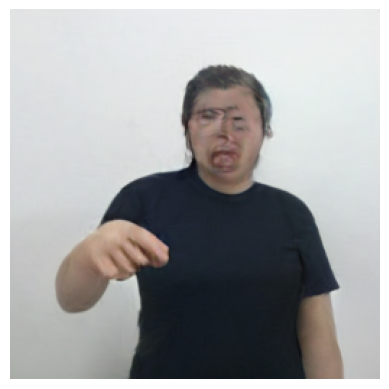

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S003936_P0000_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000042.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000042.pt
encoded tokens: tensor([[[2316, 2896, 2968,  705,  730, 2987, 2859, 3178,  775, 3836, 2810,
          3739, 2058, 3372, 1031, 3161, 1205,  954,  595, 1265,  957, 2858,
           504,  498,  562, 1430, 4067, 3160, 3990, 2444,   75, 2472]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


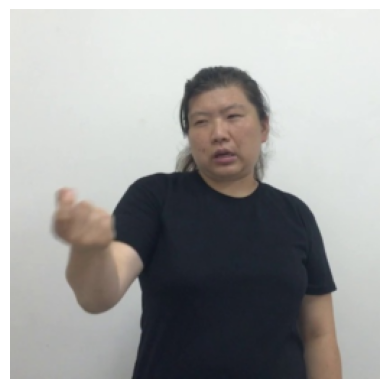

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


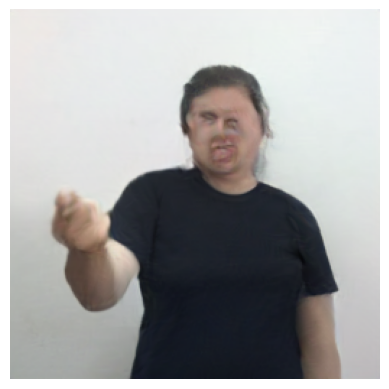

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S006072_P0006_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000073.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000073.pt
encoded tokens: tensor([[[1457, 1252, 1002,  801,  914, 3564, 2407, 1847, 3304, 1873,   90,
          2271, 2058,  673, 1509,  142, 2937,  319, 3953, 3694, 3680,  360,
           975, 1202, 2617, 3863,  579, 2713, 1509, 4081,  971, 1095]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


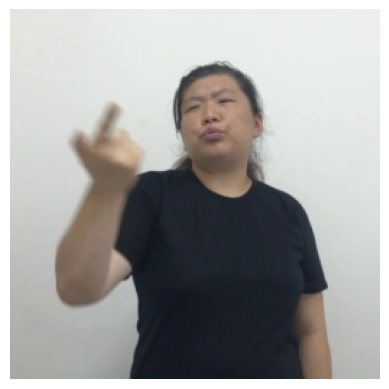

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


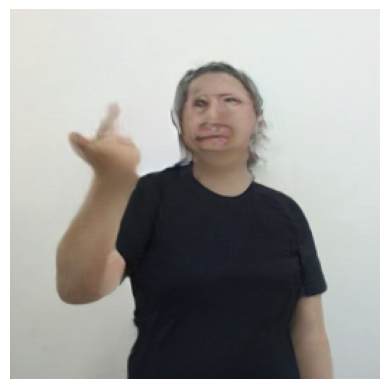

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S007118_P0007_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000064.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000064.pt
encoded tokens: tensor([[[ 571,  913, 2006,  657, 1729, 1007, 3265,  160, 1884, 2413, 3664,
          1306, 3554, 1957,  584, 3490, 2072,  107,  666, 3809,  657, 1929,
          2215,  199,  723, 2199, 1073,  171,  951, 3449,  556,  121]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


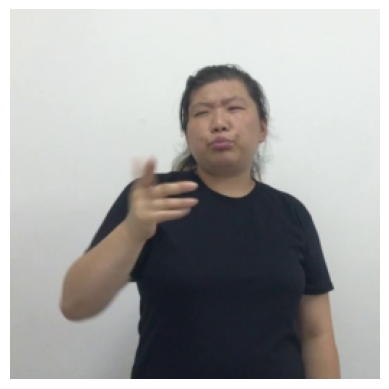

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


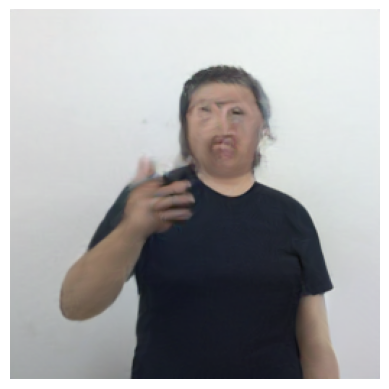

random folder: ../../../CSL-Daily/sentence/frames_512x512//dev\S001702_P0005_T00
random image: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000054.jpg
random token file: ../../../CSL-Daily/sentence/frames_512x512//dev\S000313_P0000_T00\000054.pt
encoded tokens: tensor([[[ 276, 3479, 3963, 3690,  447, 2055, 1839,   27, 3653,  599, 1265,
          2505, 2058, 3705,  291, 3951, 1240, 2311,  595, 1124, 1902,  146,
           916, 1890, 1491,   70, 1452, 1716, 2287, 2858, 3847, 2733]]],
       device='cuda:0')
orginal image: torch.Size([3, 256, 256])


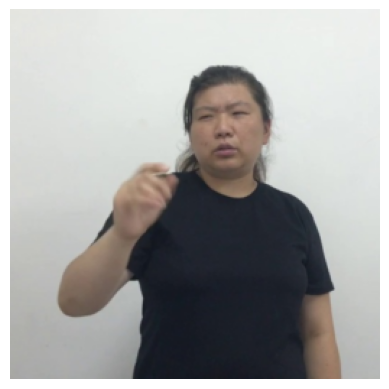

encoded tokens: torch.Size([1, 1, 32])
reconstructed image: (256, 256, 3)


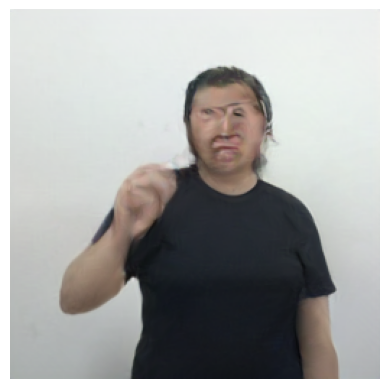

In [6]:

for i in range(5): 
    # Select a random folder
    random_folder = random.choice(folders)
    print(f"random folder: {random_folder}")
    # Get a list of all images in the selected folder
    analyse_tensor = True 
    random_image_path = random.choice(images)
    print(f"random image: {random_image_path}")
    if analyse_tensor : 
        random_token = os.path.splitext(random_image_path)[0] + ".pt"
        print(f"random token file: {random_token}")
        random_token = torch.load(random_token).unsqueeze(0).unsqueeze(0).cuda()
        print(f"encoded tokens: {random_token}")
    else: 
        images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    # Select a random image
    




    # Get the reconstuction + Display the reconstructed image
    tokenize_and_reconstruct(model=model, img_path=random_image_path, encoded_tokens=random_token)